In [1]:
!pip install --upgrade nbformat

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.V82DL4_0.2.0/stanford_dogs-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.V82DL4_0.2.0/stanford_dogs-test.tfrecord*...:   0…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 164s 515ms/step - accuracy: 0.1035 - loss: 4.4977 - val_accuracy: 0.5675 - val_loss: 3.1315
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 151s 494ms/step - accuracy: 0.6180 - loss: 2.6793 - val_accuracy: 0.7392 - val_loss: 1.5274
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 147s 478ms/step - accuracy: 0.7643 - loss: 1.3434 - val_accuracy: 0.7842 - val_loss: 0.9742
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 150s 492ms/step - accuracy: 0.8126 - loss: 0.8839 - val_accuracy: 0.8021 - val_loss: 0.7824
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 145s 474ms/step - accuracy: 0.8315 - loss: 0.7108 - val_accuracy: 0.8158 - val_loss: 0.6837
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 146s 478ms/step - accuracy: 0.8558 - loss: 0.5979 - val_accuracy: 0.8233 - val_loss: 0.6264
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 144s 473ms/step - accuracy: 0.852

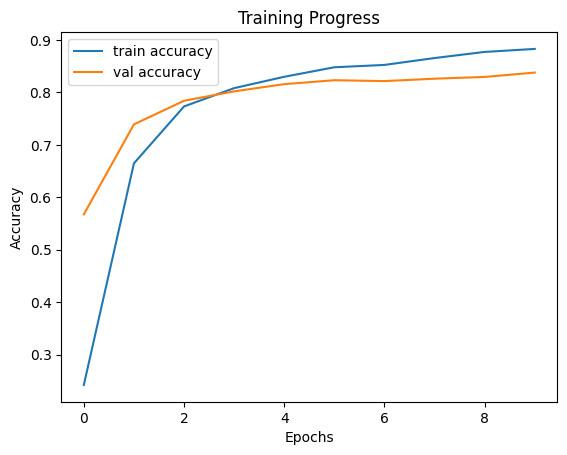

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


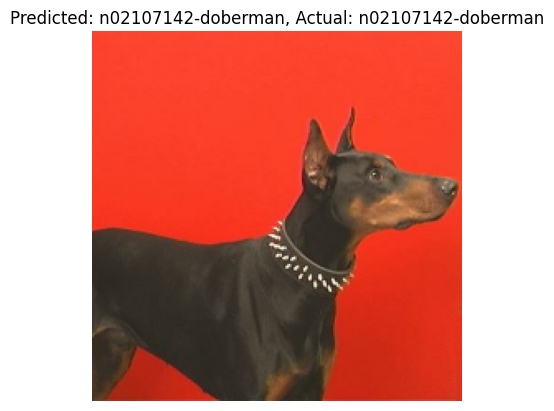

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


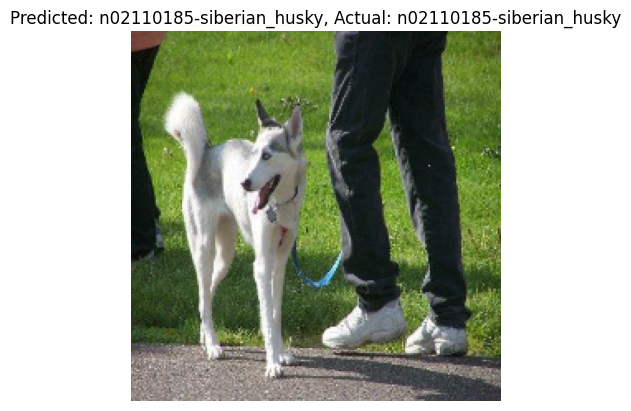

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


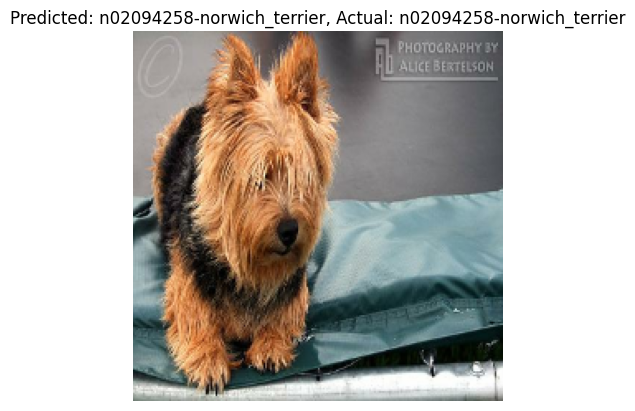

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


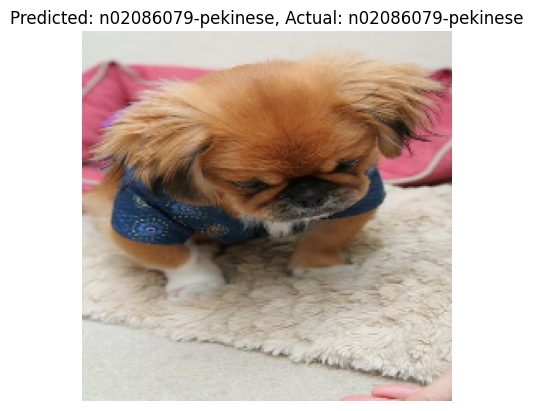

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


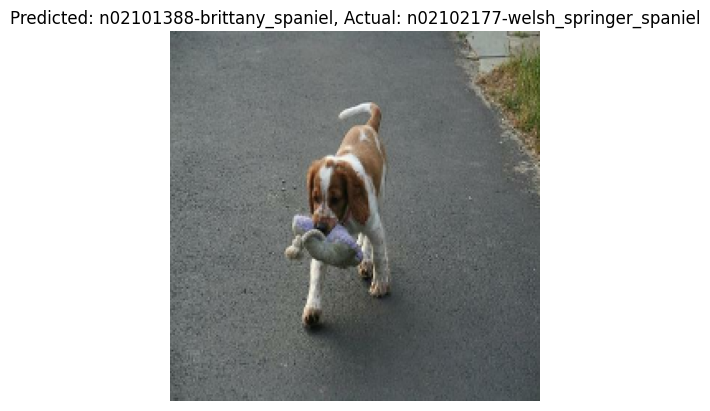

In [2]:
# Import required libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# Load the Stanford Dogs dataset
dataset_name = "stanford_dogs"
(train_ds, val_ds), dataset_info = tfds.load(dataset_name, split=['train[:80%]', 'train[80%:]'],
                                             as_supervised=True, with_info=True)

# Function to preprocess images
def format_image(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0  # Resize and normalize
    return image, label

# Apply preprocessing
batch_size = 32
train_ds = train_ds.map(format_image).batch(batch_size).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(format_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Load EfficientNet from TensorFlow Hub
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
feature_extractor = hub.KerasLayer(efficientnet_url, trainable=True)  # Fine-tuning enabled

# Functional API: Define Input Layer
inputs = tf.keras.Input(shape=(224, 224, 3))

# Pass input through feature extractor
x = tf.keras.layers.Lambda(lambda input_tensor: feature_extractor(input_tensor))(inputs)

# Add additional layers for fine-tuning
x = tf.keras.layers.Dropout(0.3)(x)  # Adding dropout for regularization
x = tf.keras.layers.Dense(256, activation='relu')(x)  # Adding an extra dense layer
outputs = tf.keras.layers.Dense(dataset_info.features['label'].num_classes, activation='softmax')(x)

# Create the fine-tuned model
model = tf.keras.Model(inputs, outputs)

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

# Plot training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Progress')
plt.show()

# Test model on a few images
def show_predictions(dataset, model, num_images=5):
    class_names = dataset_info.features['label'].names
    for image, label in dataset.take(num_images):
        pred = model.predict(tf.expand_dims(image, axis=0))
        predicted_class = class_names[np.argmax(pred)]
        actual_class = class_names[label.numpy()]

        plt.imshow(image)
        plt.title(f"Predicted: {predicted_class}, Actual: {actual_class}")
        plt.axis('off')
        plt.show()

# Show predictions on validation set
show_predictions(val_ds.unbatch(), model, num_images=5)
